In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn import metrics
from math import sqrt

df = pd.read_csv('result.csv')
# cols_drop = []
# for col in df.columns.values:
#     if df[col].isnull().sum()/ 480.0 > 0.5:
#         cols_drop.append(col)
# df = df.drop(cols_drop, axis=1)
# print(df)
df = df.fillna(0)
#print(df)
region = df.region_name.unique()

def split_region(i):
    val_state = np.array([region[3*i], region[3*i+1], region[3*i+2]])
    train = df.loc[~np.in1d(df['region_name'], val_state)]
    val = df.loc[np.in1d(df['region_name'], val_state)]
    return (train, val)

def cross_val(neigh,typ):
    score_list_cv = []
    
    if typ == "region":
        for i in range(0,5):
            train, val = split_region(i)
            x_train = train.iloc[:,2:-1]
            y_train = train.iloc[:, -1]
            x_val = val.iloc[:,2:-1]
            y_val = val.iloc[:,-1] 
    
            neigh.fit(x_train, y_train)
            y_pred = neigh.predict(x_val)
            score_list_cv.append(sqrt(metrics.mean_squared_error(y_val,y_pred)))
        return min(score_list_cv)
    
    elif typ == "time":
        for i in range(0,2):
            if i == 0:
                train = df.loc[df['date'] < '2020-08-10']
                val = df.loc[df['date'] >= '2020-08-10']
            else:
                train = df.loc[df['date'] >= '2020-08-10']
                val = df.loc[df['date'] < '2020-08-10']
            
            x_train = train.iloc[:,2:-1]
            y_train = train.iloc[:, -1]
            x_val = val.iloc[:,2:-1]
            y_val = val.iloc[:,-1] 
        
            neigh.fit(x_train, y_train)
            y_pred = neigh.predict(x_val)
            score_list_cv.append(sqrt(metrics.mean_squared_error(y_val,y_pred)))
        return min(score_list_cv)
        
    return 0
    

#time_train = df.loc[df['date'] < '2020-08-10']
#time_val = df.loc[df['date'] >= '2020-08-10']


In [2]:
score_list = []
for k in range(1,100):
    '''
    score_list_cv = []
    for i in range(0,4):
        train, val = split_region(i)
        x_train = train.iloc[:,2:-1]
        y_train = train.iloc[:, -1]
        x_val = val.iloc[:,2:-1]
        y_val = val.iloc[:,-1] 
    
        neigh = KNN(k)
        neigh.fit(x_train, y_train)
        y_pred = neigh.predict(x_val)
        score_list_cv.append(sqrt(metrics.mean_absolute_error(y_val,y_pred)))
    score_list.append(min(score_list_cv))
    '''
    score_list.append(cross_val(KNN(k),"region"))


In [3]:
print(min(score_list))
print(score_list)

4.823553323709262
[5.131601439446884, 4.823553323709262, 5.780234520424852, 5.719119978924497, 5.708667873408724, 5.637013919259552, 5.855671514770008, 5.972157622389639, 5.993412021071219, 6.102913693929774, 6.1461164547010885, 6.199163623395468, 6.1776409626367785, 6.194339453875713, 6.199940262555702, 6.225897971823467, 6.181355055875482, 6.12080039952817, 6.069866131456374, 6.022504093444483, 6.021302571378111, 6.034664176006128, 6.026030490983336, 6.009637321897283, 5.99121579202975, 6.001495540109041, 5.974190028954353, 5.962115848993996, 5.934573033346426, 5.9468634745708755, 5.921923304741472, 5.90118279104565, 5.899437854861004, 5.8793145747851465, 5.8878944952590295, 5.867229560537868, 5.849154863107371, 5.822270210953517, 5.816226442332694, 5.806103110807914, 5.8041663383701225, 5.800816399393356, 5.796260935022972, 5.788027524663529, 5.775619254917847, 5.765275864787517, 5.753013394784283, 5.754366297124426, 5.747246210340006, 5.737285459557023, 5.7305130622333476, 5.726718

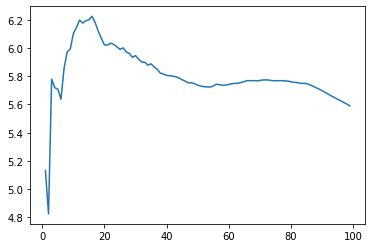

In [4]:
plt.plot(range(1,100),score_list)

4.4603178515635316
[4.4603178515635316, 4.80579931652447, 4.859608214219799, 4.670921234907506, 5.0507148530071655, 5.0143527131512, 5.061740162218088, 4.810474524924841, 4.7571500071446335, 4.567335245952868, 4.541961224482865, 4.867225066339298, 5.044238298961345, 5.309748990624166, 5.398087795863629, 5.217429312166192, 5.077049436083026]


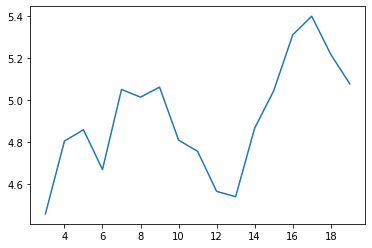

In [5]:
score_list = []
for k in range(3,20):
    #score_list.append(cross_val(DTR(max_depth=k)))
    score_list.append(cross_val(DTR(max_depth=k,random_state=10),"region"))
    
print(min(score_list))
print(score_list)
plt.plot(range(3,20),score_list)

4.686483223057563
[5.95622048785973, 5.364451859230353, 5.469136891076446, 5.387884267038408, 5.3621940472161205, 5.26584909265986, 5.187661357215105, 5.031347048753445, 5.019666185226973, 5.135659646043535, 5.119384395697308, 5.186495886755655, 5.136127694314823, 5.11300861947808, 5.080959145017142, 5.03338464032901, 4.95596417282782, 4.873886981204587, 4.836853111922646, 4.793142888544009, 4.801529704167204, 4.757096970938168, 4.729755198647223, 4.711466509131383, 4.686483223057563, 4.727521457869376, 4.737526262997662, 4.754168753390469, 4.741655556215899, 4.752274674651428, 4.747293371473761, 4.773814684361449, 4.792572378170203, 4.805213161703835, 4.826845501981599, 4.866267106885478, 4.867696365366825, 4.902880799242314, 4.9368203849057055, 4.9445953765197, 4.943834698327832, 5.013263657538869, 5.028443804302008, 5.022781905297284, 5.019994743246473, 5.0376807066520115, 5.069251145963382, 5.1015565179903675, 5.144097072750236, 5.191790394459314, 5.234059015191728, 5.2585638714752

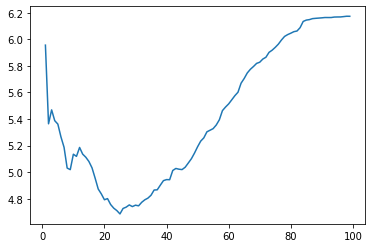

In [6]:
score_list = []
for k in range(1,100):
    score_list.append(cross_val(KNN(k),"time"))

print(min(score_list))
print(score_list)
plt.plot(range(1,100),score_list)

5.155450144089314
[5.181400707971603, 5.370630265209197, 5.292679572604852, 6.7011660719654, 5.155450144089314, 6.538006595290455, 5.3263107102612945, 6.875439312262682, 6.746768949419338, 6.737295142216447, 6.6881501408496815, 6.784940432064725, 5.465445430154801, 5.524094948496089, 5.46151306873837, 5.46151306873837, 5.46151306873837]


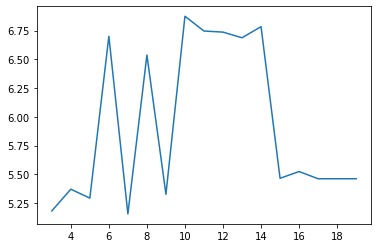

In [7]:
score_list = []
for k in range(3,20):
    #score_list.append(cross_val(DTR(max_depth=k)))
    score_list.append(cross_val(DTR(max_depth=k,random_state=10),"time"))
    
print(min(score_list))
print(score_list)
plt.plot(range(3,20),score_list)